In [2]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane

The Quantum Graph Recurrent Neural Network
==========================================

::: {.meta}
:property=\"og:description\": Using a quantum graph recurrent neural
network to learn quantum dynamics. :property=\"og:image\":
<https://pennylane.ai/qml/_images/qgrnn_thumbnail.png>
:::

*Author: Jack Ceroni --- Posted: 27 July 2020. Last updated: 25 March
2021.*


This demonstration investigates quantum graph recurrent neural networks
(QGRNN), which are the quantum analogue of a classical graph recurrent
neural network, and a subclass of the more general quantum graph neural
network ansatz. Both the QGNN and QGRNN were introduced in [this paper
(2019)](https://arxiv.org/abs/1909.12264).


The Idea
========


A graph is defined as a set of *nodes* along with a set of **edges**,
which represent connections between nodes. Information can be encoded
into graphs by assigning numbers to nodes and edges, which we call
**weights**. It is usually convenient to think of a graph visually:

![image](../demonstrations/qgrnn/graph.png){.align-center width="70.0%"}

In recent years, the concept of a [graph neural
network](https://arxiv.org/abs/1812.08434) (GNN) has been receiving a
lot of attention from the machine learning community. A GNN seeks to
learn a representation (a mapping of data into a low-dimensional vector
space) of a given graph with feature vectors assigned to nodes and
edges. Each of the vectors in the learned representation preserves not
only the features, but also the overall topology of the graph, i.e.,
which nodes are connected by edges. The quantum graph neural network
attempts to do something similar, but for features that are
quantum-mechanical; for instance, a collection of quantum states.


Consider the class of qubit Hamiltonians that are *quadratic*, meaning
that the terms of the Hamiltonian represent either interactions between
two qubits, or the energy of individual qubits. This class of
Hamiltonians is naturally described by graphs, with second-order terms
between qubits corresponding to weighted edges between nodes, and
first-order terms corresponding to node weights.

A well known example of a quadratic Hamiltonian is the transverse-field
Ising model, which is defined as

$$\hat{H}_{\text{Ising}}(\boldsymbol\theta) \ = \ \displaystyle\sum_{(i, j) \in E}
\theta_{ij}^{(1)} Z_{i} Z_{j} \ + \ \displaystyle\sum_{i} \theta_{i}^{(2)} Z_{i} \ + \
\displaystyle\sum_{i} X_{i},$$

where $\boldsymbol\theta \ = \ \{\theta^{(1)}, \ \theta^{(2)}\}$. In
this Hamiltonian, the set $E$ that determines which pairs of qubits have
$ZZ$ interactions can be represented by the set of edges for some graph.
With the qubits as nodes, this graph is called the *interaction graph*.
The $\theta^{(1)}$ parameters correspond to the edge weights and the
$\theta^{(2)}$ parameters correspond to weights on the nodes.


This result implies that we can think about *quantum circuits* with
graph-theoretic properties. Recall that the time-evolution operator with
respect to some Hamiltonian $H$ is defined as:

$$U \ = \ e^{-it H}.$$

Thus, we have a clean way of taking quadratic Hamiltonians and turning
them into unitaries (quantum circuits) that preserve the same
correspondance to a graph. In the case of the Ising Hamiltonian, we
have:

$$U_{\text{Ising}} \ = \ e^{-it \hat{H}_{\text{Ising}} (\boldsymbol\theta)} \ = \ \exp \Big[ -it
\Big( \displaystyle\sum_{(i, j) \in E} \theta_{ij}^{(1)} Z_{i} Z_{j} \ + \
\displaystyle\sum_{i} \theta_{i}^{(2)} Z_{i} \ + \ \displaystyle\sum_{i} X_{i} \Big) \Big]$$

In general, this kind of unitary is very difficult to implement on a
quantum computer. However, we can approximate it using the
[Trotter-Suzuki
decomposition](https://en.wikipedia.org/wiki/Time-evolving_block_decimation#The_Suzuki-Trotter_expansion):

$$\exp \Big[ -it \Big( \displaystyle\sum_{(i, j) \in E} \theta_{ij}^{(1)} Z_{i} Z_{j} \ + \
\displaystyle\sum_{i} \theta_{i}^{(2)} Z_{i} \ + \ \displaystyle\sum_{i} X_{i} \Big) \Big]
\ \approx \ \displaystyle\prod_{k \ = \ 1}^{t / \Delta} \Bigg[ \displaystyle\prod_{j \ = \
1}^{Q} e^{-i \Delta \hat{H}_{\text{Ising}}^{j}(\boldsymbol\theta)} \Bigg]$$

where $\hat{H}_{\text{Ising}}^{j}(\boldsymbol\theta)$ is the $j$-th term
of the Ising Hamiltonian and $\Delta$ is some small number.

This circuit is a specific instance of the **Quantum Graph Recurrent
Neural Network**, which in general is defined as a variational ansatz of
the form

$$U_{H}(\boldsymbol\mu, \ \boldsymbol\gamma) \ = \ \displaystyle\prod_{i \ = \ 1}^{P} \Bigg[
\displaystyle\prod_{j \ = \ 1}^{Q} e^{-i \gamma_j H^{j}(\boldsymbol\mu)} \Bigg],$$

for some parametrized quadratic Hamiltonian, $H(\boldsymbol\mu)$.


Using the QGRNN
===============


Since the QGRNN ansatz is equivalent to the approximate time evolution
of some quadratic Hamiltonian, we can use it to learn the dynamics of a
quantum system.

Continuing with the Ising model example, let\'s imagine we have some
system governed by $\hat{H}_{\text{Ising}}(\boldsymbol\alpha)$ for an
unknown set of target parameters, $\boldsymbol\alpha$ and an unknown
interaction graph $G$. Let\'s also suppose we have access to copies of
some low-energy, non-ground state of the target Hamiltonian,
$|\psi_0\rangle$. In addition, we have access to a collection of
time-evolved states,
$\{ |\psi(t_1)\rangle, \ |\psi(t_2)\rangle, \ ..., \ |\psi(t_N)\rangle \}$,
defined by:

$$|\psi(t_k)\rangle \ = \ e^{-i t_k \hat{H}_{\text{Ising}}(\boldsymbol\alpha)} |\psi_0\rangle.$$

We call the low-energy states and the collection of time-evolved states
*quantum data*. From here, we randomly pick a number of time-evolved
states from our collection. For any state that we choose, which is
evolved to some time $t_k$, we compare it to

$$U_{\hat{H}_{\text{Ising}}}(\boldsymbol\mu, \ \Delta) |\psi_0\rangle \ \approx \ e^{-i t_k
\hat{H}_{\text{Ising}}(\boldsymbol\mu)} |\psi_0\rangle.$$

This is done by feeding one of the copies of $|\psi_0\rangle$ into a
quantum circuit with the QGRNN ansatz, with some guessed set of
parameters $\boldsymbol\mu$ and a guessed interaction graph, $G'$. We
then use a classical optimizer to maximize the average \"similarity\"
between the time-evolved states and the states prepared with the QGRNN.

As the QGRNN states becomes more similar to each time-evolved state for
each sampled time, it follows that
$\boldsymbol\mu \ \rightarrow \ \boldsymbol\alpha$ and we are able to
learn the unknown parameters of the Hamiltonian.

![A visual representation of one execution of the QGRNN for one piece of
quantum data.](../demonstrations/qgrnn/qgrnn3.png){.align-center
width="90.0%"}


Learning an Ising Model with the QGRNN
======================================


We now attempt to use the QGRNN to learn the parameters corresponding to
an arbitrary transverse-field Ising model Hamiltonian.


Getting Started
===============


We begin by importing the necessary dependencies:


In [3]:
import pennylane as qml
from matplotlib import pyplot as plt
from pennylane import numpy as np
import scipy
import networkx as nx
import copy

We also define some fixed values that are used throughout the
simulation.


In [4]:
qubit_number = 4
qubits = range(qubit_number)

In this simulation, we don\'t have quantum data readily available to
pass into the QGRNN, so we have to generate it ourselves. To do this, we
must have knowledge of the target interaction graph and the target
Hamiltonian.

Let us use the following cyclic graph as the target interaction graph of
the Ising Hamiltonian:


Edges: [(0, 1), (0, 3), (1, 2), (2, 3)]


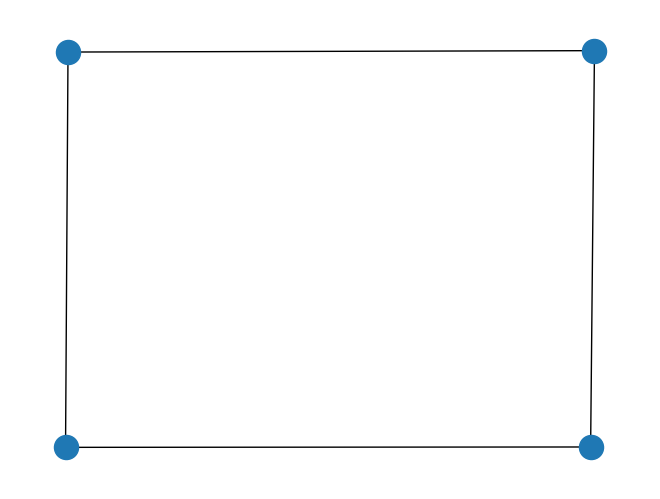

In [5]:
ising_graph = nx.cycle_graph(qubit_number)

print(f"Edges: {ising_graph.edges}")
nx.draw(ising_graph)

We can then initialize the "unknown" target parameters that describe the
target Hamiltonian,
$\boldsymbol\alpha \ = \ \{\alpha^{(1)}, \ \alpha^{(2)}\}$. Recall from
the introduction that we have defined our parametrized Ising Hamiltonian
to be of the form:

$$\hat{H}_{\text{Ising}}(\boldsymbol\theta) \ = \ \displaystyle\sum_{(i, j) \in E}
\theta_{ij}^{(1)} Z_{i} Z_{j} \ + \ \displaystyle\sum_{i} \theta_{i}^{(2)} Z_{i} \ + \
\displaystyle\sum_{i} X_{i},$$

where $E$ is the set of edges in the interaction graph, and $X_i$ and
$Z_i$ are the Pauli-X and Pauli-Z on the $i$-th qubit.

For this tutorial, we choose the target parameters by sampling from a
uniform probability distribution ranging from $-2$ to $2$, with
two-decimal precision.


In [6]:
target_weights = [0.56, 1.24, 1.67, -0.79]
target_bias = [-1.44, -1.43, 1.18, -0.93]

In theory, these parameters can be any value we want, provided they are
reasonably small enough that the QGRNN can reach them in a tractable
number of optimization steps. In `matrix_params`, the first list
represents the $ZZ$ interaction parameters and the second list
represents the single-qubit $Z$ parameters.

Finally, we use this information to generate the matrix form of the
Ising model Hamiltonian in the computational basis:


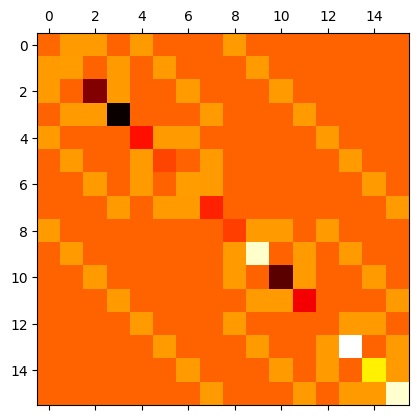

In [7]:
def create_hamiltonian_matrix(n_qubits, graph, weights, bias):

    full_matrix = np.zeros((2 ** n_qubits, 2 ** n_qubits))

    # Creates the interaction component of the Hamiltonian
    for i, edge in enumerate(graph.edges):
        interaction_term = 1
        for qubit in range(0, n_qubits):
            if qubit in edge:
                interaction_term = np.kron(interaction_term, qml.matrix(qml.PauliZ)(0))
            else:
                interaction_term = np.kron(interaction_term, np.identity(2))
        full_matrix += weights[i] * interaction_term

    # Creates the bias components of the matrix
    for i in range(0, n_qubits):
        z_term = x_term = 1
        for j in range(0, n_qubits):
            if j == i:
                z_term = np.kron(z_term, qml.matrix(qml.PauliZ)(0))
                x_term = np.kron(x_term, qml.matrix(qml.PauliX)(0))
            else:
                z_term = np.kron(z_term, np.identity(2))
                x_term = np.kron(x_term, np.identity(2))
        full_matrix += bias[i] * z_term + x_term

    return full_matrix


# Prints a visual representation of the Hamiltonian matrix
ham_matrix = create_hamiltonian_matrix(qubit_number, ising_graph, target_weights, target_bias)
plt.matshow(ham_matrix, cmap="hot")
plt.show()

Preparing Quantum Data
======================


The collection of quantum data needed to run the QGRNN has two
components: (i) copies of a low-energy state, and (ii) a collection of
time-evolved states, each of which are simply the low-energy state
evolved to different times. The following is a low-energy state of the
target Hamiltonian:


In [8]:
low_energy_state = [
    (-0.054661080280306085 + 0.016713907320174026j),
    (0.12290003656489545 - 0.03758500591109822j),
    (0.3649337966440005 - 0.11158863596657455j),
    (-0.8205175732627094 + 0.25093231967092877j),
    (0.010369790825776609 - 0.0031706387262686003j),
    (-0.02331544978544721 + 0.007129899300113728j),
    (-0.06923183949694546 + 0.0211684344103713j),
    (0.15566094863283836 - 0.04760201916285508j),
    (0.014520590919500158 - 0.004441887836078486j),
    (-0.032648113364535575 + 0.009988590222879195j),
    (-0.09694382811137187 + 0.02965579457620536j),
    (0.21796861485652747 - 0.06668776658411019j),
    (-0.0027547112135013247 + 0.0008426289322652901j),
    (0.006193695872468649 - 0.0018948418969390599j),
    (0.018391279795405405 - 0.005625722994009138j),
    (-0.041350974715649635 + 0.012650711602265649j),
]

This state can be obtained by using a decoupled version of the
`Variational Quantum Eigensolver </demos/tutorial_vqe>`{.interpreted-text
role="doc"} algorithm (VQE). Essentially, we choose a VQE ansatz such
that the circuit cannot learn the exact ground state, but it can get
fairly close. Another way to arrive at the same result is to perform VQE
with a reasonable ansatz, but to terminate the algorithm before it
converges to the ground state. If we used the exact ground state
$|\psi_0\rangle$, the time-dependence would be trivial and the data
would not provide enough information about the Hamiltonian parameters.

We can verify that this is a low-energy state by numerically finding the
lowest eigenvalue of the Hamiltonian and comparing it to the energy
expectation of this low-energy state:


In [9]:
res = np.vdot(low_energy_state, (ham_matrix @ low_energy_state))
energy_exp = np.real_if_close(res)
print(f"Energy Expectation: {energy_exp}")


ground_state_energy = np.real_if_close(min(np.linalg.eig(ham_matrix)[0]))
print(f"Ground State Energy: {ground_state_energy}")

Energy Expectation: -7.244508985189116
Ground State Energy: -7.330689661291244


We have in fact found a low-energy, non-ground state, as the energy
expectation is slightly greater than the energy of the true ground
state. This, however, is only half of the information we need. We also
require a collection of time-evolved, low-energy states. Evolving the
low-energy state forward in time is fairly straightforward: all we have
to do is multiply the initial state by a time-evolution unitary. This
operation can be defined as a custom gate in PennyLane:


In [10]:
def state_evolve(hamiltonian, qubits, time):

    U = scipy.linalg.expm(-1j * hamiltonian * time)
    qml.QubitUnitary(U, wires=qubits)

We don\'t actually generate time-evolved quantum data quite yet, but we
now have all the pieces required for its preparation.


Learning the Hamiltonian
========================


With the quantum data defined, we are able to construct the QGRNN and
learn the target Hamiltonian. Each of the exponentiated Hamiltonians in
the QGRNN ansatz, $\hat{H}^{j}_{\text{Ising}}(\boldsymbol\mu)$, are the
$ZZ$, $Z$, and $X$ terms from the Ising Hamiltonian. This gives:


In [11]:
def qgrnn_layer(weights, bias, qubits, graph, trotter_step):

    # Applies a layer of RZZ gates (based on a graph)
    for i, edge in enumerate(graph.edges):
        qml.MultiRZ(2 * weights[i] * trotter_step, wires=(edge[0], edge[1]))

    # Applies a layer of RZ gates
    for i, qubit in enumerate(qubits):
        qml.RZ(2 * bias[i] * trotter_step, wires=qubit)

    # Applies a layer of RX gates
    for qubit in qubits:
        qml.RX(2 * trotter_step, wires=qubit)

As was mentioned in the first section, the QGRNN has two registers. In
one register, some piece of quantum data $|\psi(t)\rangle$ is prepared
and in the other we have
$U_{H}(\boldsymbol\mu, \ \Delta) |\psi_0\rangle$. We need a way to
measure the similarity between these states. This can be done by using
the fidelity, which is simply the modulus squared of the inner product
between the states,
$| \langle \psi(t) | U_{H}(\Delta, \ \boldsymbol\mu) |\psi_0\rangle |^2$.
To calculate this value, we use a [SWAP
test](https://en.wikipedia.org/wiki/Swap_test) between the registers:


In [12]:
def swap_test(control, register1, register2):

    qml.Hadamard(wires=control)
    for reg1_qubit, reg2_qubit in zip(register1, register2):
        qml.CSWAP(wires=(control, reg1_qubit, reg2_qubit))
    qml.Hadamard(wires=control)

After performing this procedure, the value returned from a measurement
of the circuit is $\langle Z \rangle$, with respect to the `control`
qubit. The probability of measuring the $|0\rangle$ state in this
control qubit is related to both the fidelity between registers and
$\langle Z \rangle$. Thus, with a bit of algebra, we find that
$\langle Z \rangle$ is equal to the fidelity.

Before creating the full QGRNN and the cost function, we define a few
more fixed values. Among these is a \"guessed\" interaction graph, which
we set to be a [complete
graph](https://en.wikipedia.org/wiki/Complete_graph). This choice is
motivated by the fact that any target interaction graph will be a
subgraph of this initial guess. Part of the idea behind the QGRNN is
that we don't know the interaction graph, and it has to be learned. In
this case, the graph is learned *automatically* as the target parameters
are optimized. The $\boldsymbol\mu$ parameters that correspond to edges
that don\'t exist in the target graph will simply approach $0$.


Edges: [(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


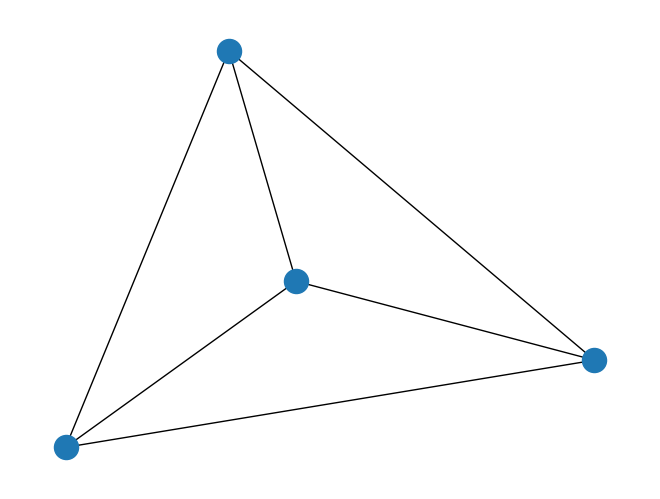

In [13]:
# Defines some fixed values

reg1 = tuple(range(qubit_number))  # First qubit register
reg2 = tuple(range(qubit_number, 2 * qubit_number))  # Second qubit register

control = 2 * qubit_number  # Index of control qubit
trotter_step = 0.01  # Trotter step size

# Defines the interaction graph for the new qubit system

new_ising_graph = nx.complete_graph(reg2)

print(f"Edges: {new_ising_graph.edges}")
nx.draw(new_ising_graph)

With this done, we implement the QGRNN circuit for some given time
value:


In [14]:
def qgrnn(weights, bias, time=None):

    # Prepares the low energy state in the two registers
    qml.QubitStateVector(np.kron(low_energy_state, low_energy_state), wires=reg1 + reg2)

    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    state_evolve(ham_matrix, reg1, time)

    # Applies the QGRNN layers to the second qubit register
    depth = time / trotter_step  # P = t/Delta
    for _ in range(0, int(depth)):
        qgrnn_layer(weights, bias, reg2, new_ising_graph, trotter_step)

    # Applies the SWAP test between the registers
    swap_test(control, reg1, reg2)

    # Returns the results of the SWAP test
    return qml.expval(qml.PauliZ(control))

We have the full QGRNN circuit, but we still need to define a cost
function. We know that
$| \langle \psi(t) | U_{H}(\boldsymbol\mu, \ \Delta) |\psi_0\rangle |^2$
approaches $1$ as the states become more similar and approaches $0$ as
the states become orthogonal. Thus, we choose to minimize the quantity
$-| \langle \psi(t) | U_{H}(\boldsymbol\mu, \ \Delta) |\psi_0\rangle |^2$.
Since we are interested in calculating this value for many different
pieces of quantum data, the final cost function is the average negative
fidelity\* between registers:

$$\mathcal{L}(\boldsymbol\mu, \ \Delta) \ = \ - \frac{1}{N} \displaystyle\sum_{i \ = \ 1}^{N} |
\langle \psi(t_i) | \ U_{H}(\boldsymbol\mu, \ \Delta) \ |\psi_0\rangle |^2,$$

where we use $N$ pieces of quantum data.

Before creating the cost function, we must define a few more fixed
variables:


In [15]:
N = 15  # The number of pieces of quantum data that are used for each step
max_time = 0.1  # The maximum value of time that can be used for quantum data

We then define the negative fidelity cost function:


In [16]:
rng = np.random.default_rng(seed=42)

def cost_function(weight_params, bias_params):

    # Randomly samples times at which the QGRNN runs
    times_sampled = rng.random(size=N) * max_time

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for dt in times_sampled:
        result = qgrnn_qnode(weight_params, bias_params, time=dt)
        total_cost += -1 * result

    return total_cost / N

Next we set up for optimization.


In [17]:
# Defines the new device
qgrnn_dev = qml.device("default.qubit", wires=2 * qubit_number + 1)

# Defines the new QNode
qgrnn_qnode = qml.QNode(qgrnn, qgrnn_dev, interface="autograd")

steps = 300

optimizer = qml.AdamOptimizer(stepsize=0.3)

weights = rng.random(size=len(new_ising_graph.edges), requires_grad=True) - 0.5
bias = rng.random(size=qubit_number, requires_grad=True) - 0.5

initial_weights = copy.copy(weights)
initial_bias = copy.copy(bias)

All that remains is executing the optimization loop.


In [18]:
for i in range(0, steps):
    (weights, bias), cost = optimizer.step_and_cost(cost_function, weights, bias)

    # Prints the value of the cost function
    if i % 5 == 0:
        print(f"Cost at Step {i}: {cost}")
        print(f"Weights at Step {i}: {weights}")
        print(f"Bias at Step {i}: {bias}")
        print("---------------------------------------------")

Cost at Step 0: -0.9803638573791906
Weights at Step 0: [-0.02603926  0.23887338  0.65859458  0.4973626  -0.10582631  0.17562606]
Bias at Step 0: [-0.03885261 -0.01392638 -0.07189834  0.25038114]
---------------------------------------------
Cost at Step 5: -0.996941435016429
Weights at Step 5: [-0.81324145  1.07476846  1.1061694   1.58556358  0.32683696 -0.30451739]
Bias at Step 5: [-0.69258221 -1.04745285  1.06920295  0.4729811 ]
---------------------------------------------
Cost at Step 10: -0.998631791121192
Weights at Step 10: [-0.42326896  0.79838566  0.61651522  1.83801512 -0.18661762  0.09585344]
Bias at Step 10: [-0.14865635 -1.13290709  1.50067486 -0.17013801]
---------------------------------------------
Cost at Step 15: -0.9989288704590784
Weights at Step 15: [-0.01780188  0.51935145  0.84042409  1.67694816 -0.08570868 -0.17039931]
Bias at Step 15: [ 0.14049396 -0.85137402  1.46620821  0.01876606]
---------------------------------------------
Cost at Step 20: -0.998987796685

With the learned parameters, we construct a visual representation of the
Hamiltonian to which they correspond and compare it to the target
Hamiltonian, and the initial guessed Hamiltonian:


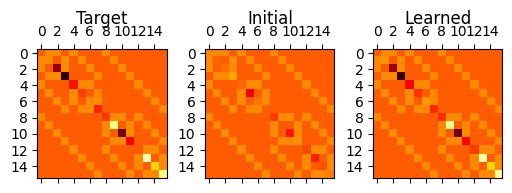

In [19]:
new_ham_matrix = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), weights, bias
)

init_ham = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), initial_weights, initial_bias
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))

axes[0].matshow(ham_matrix, vmin=-7, vmax=7, cmap="hot")
axes[0].set_title("Target", y=1.13)

axes[1].matshow(init_ham, vmin=-7, vmax=7, cmap="hot")
axes[1].set_title("Initial", y=1.13)

axes[2].matshow(new_ham_matrix, vmin=-7, vmax=7, cmap="hot")
axes[2].set_title("Learned", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

These images look very similar, indicating that the QGRNN has done a
good job learning the target Hamiltonian.

We can also look at the exact values of the target and learned
parameters. Recall how the target interaction graph has $4$ edges while
the complete graph has $6$. Thus, as the QGRNN converges to the optimal
solution, the weights corresponding to edges $(1, 3)$ and $(2, 0)$ in
the complete graph should go to $0$, as this indicates that they have no
effect, and effectively do not exist in the learned Hamiltonian.


In [20]:
# We first pick out the weights of edges (1, 3) and (2, 0)
# and then remove them from the list of target parameters

weights_noedge = []
weights_edge = []
for ii, edge in enumerate(new_ising_graph.edges):
    if (edge[0] - qubit_number, edge[1] - qubit_number) in ising_graph.edges:
        weights_edge.append(weights[ii])
    else:
        weights_noedge.append(weights[ii])

Then, we print all of the weights:


In [21]:
print("Target parameters     Learned parameters")
print("Weights")
print("-" * 41)
for ii_target, ii_learned in zip(target_weights, weights_edge):
    print(f"{ii_target : <20}|{ii_learned : >20}")

print("\nBias")
print("-"*41)
for ii_target, ii_learned in zip(target_bias, bias):
    print(f"{ii_target : <20}|{ii_learned : >20}")

print(f"\nNon-Existing Edge Parameters: {[val.unwrap() for val in weights_noedge]}")

Target parameters     Learned parameters
Weights
-----------------------------------------
0.56                |  0.5974609311535144
1.24                |  1.3411495568824126
1.67                |   1.784741915545322
-0.79               | -0.8434429713923873

Bias
-----------------------------------------
-1.44               | -1.4067252706628723
-1.43               | -1.3546960101894798
1.18                |  1.0354062517348281
-0.93               | -1.0615531663839644

Non-Existing Edge Parameters: [-0.0013558219901317857, -0.0007373999961358714]


The weights of edges $(1, 3)$ and $(2, 0)$ are very close to $0$,
indicating we have learned the cycle graph from the complete graph. In
addition, the remaining learned weights are fairly close to those of the
target Hamiltonian. Thus, the QGRNN is functioning properly, and has
learned the target Ising Hamiltonian to a high degree of accuracy!


References
==========

1.  Verdon, G., McCourt, T., Luzhnica, E., Singh, V., Leichenauer, S., &
    Hidary, J. (2019). Quantum Graph Neural Networks. arXiv preprint
    [arXiv:1909.12264](https://arxiv.org/abs/1909.12264).

About the author
================
